# Markov-Chain Monte Carlo in EasyVVUQ

We have a model that returns an array of 50 integers where each is supposed to have come from a Poisson distribution with an unknown mean. The model has four input parameters ```a, b, c, d``` and the values of the means depend on the values of those parameters (albeit indirectly).

In [1]:
import numpy as np
def model(a, b, c, d):
    a = int(a)
    b = int(b)
    c = int(c)
    d = int(d)
    x = np.linspace(0, 1, 50)
    return np.random.poisson(
        a * (0.5 * np.sin(2.0 * np.pi * x) + 1.0) +\
        b * (0.5 * np.sin(4.0 * np.pi * x) + 1.0) +\
        c * (0.5 * np.sin(6.0 * np.pi * x) + 1.0) +\
        d * (0.5 * np.sin(8.0 * np.pi * x) + 1.0))

If we plot the values returned by the model with ```a = b = c = d = 50``` and repeat this 20 times we might get something like the figure below.

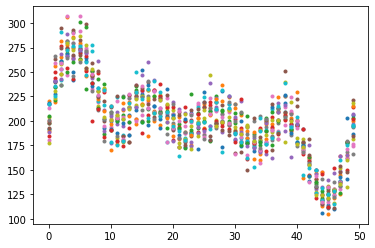

In [2]:
import matplotlib.pyplot as plt
for _ in range(20):
    plt.plot(model(50, 50, 50, 50), '.')

Then we have an array of 50 values that came from the model. With ```a = 50, b = 80, c = 50 and d = 80```. We will treat them as our observed data. We want to know what input parameters of the model are most likely to result in the values in the ```observed``` array. Because suppose we forgot. In most cases this would be values obtained by measuring whatever physical phenomenon the simulation is supposed to model.

In [3]:
observed = np.array([248, 311, 344, 370, 375, 369, 302, 306, 285, 281, 258, 248, 254,
       273, 292, 268, 312, 269, 230, 244, 227, 219, 247, 233, 225, 238,
       271, 307, 294, 299, 248, 249, 271, 255, 231, 225, 243, 279, 271,
       294, 237, 247, 197, 180, 161, 168, 178, 207, 204, 258])

I'm not a statistician so take the following with a modicum of salt. More precisely we are interested in $\mathbb{E}(X | y)$ with $X = [A, B, C, D]^T$ where $A, B, C, D$ are the random variables representing the input parameters. For this we need to know the probability density $f_{X|y}$ where $y$ are our observed values. From Bayes theorem it follows that $f_{X|y}$ is proportional to $f_{Y|X}(y|X)f(X)$. We usually know $f(X)$ in advance. being the joint probability distribution of the input parameter values given some observed values $x$. We know by Bayes theorem that this is proportional to $E(g(x | a, b, c, d) f(a, b, c, d))$. We will use Markov-Chain Monte Carlo (MCMC) to approximate the probability density $g(x | a, b, c, d)$. Namely the probability density of $x$ taking on given values with respect to the input parameters. We know that $x$ is 50 numbers from 50 Poisson distributions with unknown means. We will estimate those means by running the model multiple times and calculating the sample mean because that is the MLE estimate for a Poisson distributed random variable. Suppose we have $\hat{\lambda}_i$ that is the estimate. Then we have $g(y | a, b, c, d) = \prod_{i = 1}^{50} \frac{\hat\lambda_i^{y_i} \exp(-\hat\lambda_i)}{{y_i}!}$. Since it is often more convenient to work with log-likelihoods we arrive at $\sum_{i = 1}^{50} \left(y_i \log(\hat\lambda_i) - \hat\lambda_i - \log({y_i}!)\right)$. Since this is an estimate special care will need to be taken when estimating convergence of the MCMC algorithm.

## Sampling

In [4]:
import easyvvuq as uq
import scipy.special
import chaospy as cp
import numpy as np
import pandas as pd
import os
import json

In [ ]:
def run_model(directory):
    json_input = os.path.join(directory, 'input.json')
    with open(json_input, "r") as fd:
        inputs = json.load(fd)
    a = inputs['a']
    b = inputs['b']
    c = inputs['c']
    d = inputs['d']
    outfile = inputs['outfile']
    data = pd.DataFrame({"Values": model(a, b, c, d)})
    data.to_csv(os.path.join(directory, outfile), index=False)

In [ ]:
def poisson_loglikelihood(lmbda, k):
    return (k * np.log(lmbda) - lmbda - scipy.special.gammaln(k + 1.0)).sum()

In [ ]:
def get_likelihood(observed):
    def likelihood(lmbda):
        return poisson_loglikelihood(lmbda, observed)
    return likelihood

In [ ]:
params = {
    "a": {"type": "float", "min": 0, "max": 100, "default": 50},
    "b": {"type": "float", "min": 0, "max": 100, "default": 50},
    "c": {"type": "float", "min": 0, "max": 100, "default": 50},
    "d": {"type": "float", "min": 0, "max": 100, "default": 50},
    "outfile": {"type": "string", "default": "output.csv"},
    "ensemble_id": {"type": "integer", "default": 0},
    "chain_id": {"type": "integer", "default": 0}
}
encoder = uq.encoders.GenericEncoder(template_fname="mcmc.template", 
                                     delimiter="$", target_filename="input.json")
decoder = uq.decoders.SimpleCSV("output.csv", ["Values"])
campaign = uq.Campaign(
    name="mcmc", encoder=encoder, decoder=decoder, 
    params=params, work_dir='.')

In [ ]:
vary_init = {
    "a": np.random.uniform(0, 100, size=5),
    "b": np.random.uniform(0, 100, size=5),
    "c": np.random.uniform(0, 100, size=5),
    "d": np.random.uniform(0, 100, size=5)
}

In [ ]:
def q(x, b=1):
    return cp.J(cp.Normal(x['a'], b), 
                cp.Normal(x['b'], b), 
                cp.Normal(x['c'], b), 
                cp.Normal(x['d'], b))

In [ ]:
mcmc_sampler = uq.sampling.MCMCSampler(
    vary_init, q, 'Values', n_chains=5, n_replicas=20,
    likelihood=get_likelihood(observed), estimator=lambda x: np.mean(x))
sampler = uq.sampling.ReplicaSampler(mcmc_sampler)
campaign.set_sampler(sampler)

In [ ]:
action = uq.actions.ExecutePython(run_model)

When we have workflows where each sampling stage relies on the results of the previous one (as is the case with MCMC) we need to call iterate on the campaign object and then use the Python keyword next to advance to the next sampling stage. This will return action statuses and we need to wait for them to finish in order to proceed.

In [ ]:
iterator = campaign.iterate(action, nsamples=100, mark_invalid=True)

In [ ]:
for _ in range(1000):
    next(iterator).start()

## Analysis

Let us now save our progress so that we do not lose it. This way we can continue the tutorial just from this point onward and not redo the sampling stage.

In [ ]:
campaign.save_state('mcmc_state.json')

In [5]:
campaign = uq.Campaign(state_file='mcmc_state.json')

After calling analyse we will get an instance of MCMCAnalysisResults that contains information about our chains. It also lets us plot and analyse that data.

In [6]:
result = campaign.analyse()

We will now plot the chains for each parameter. We can see that they indeed seem to converge to the input parameters used to generate observed data. Which was $a = 50, b = 80, c = 50, d = 80$.

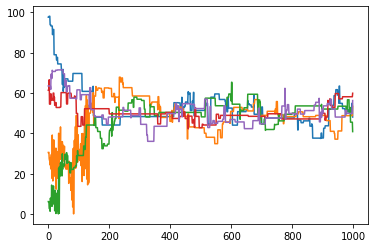

In [7]:
result.plot_chains('a')

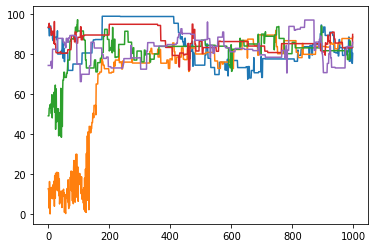

In [8]:
result.plot_chains('b')

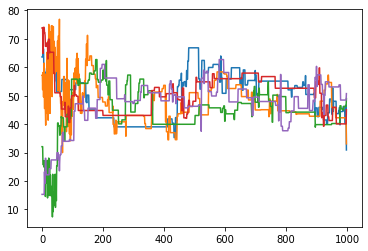

In [9]:
result.plot_chains('c')

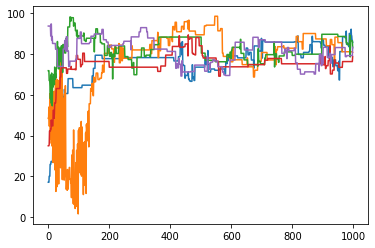

In [10]:
result.plot_chains('d')

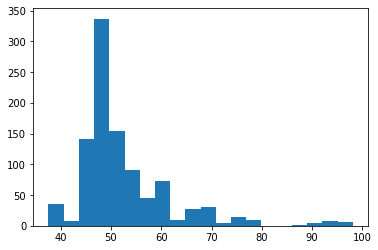

In [11]:
result.plot_hist('a')

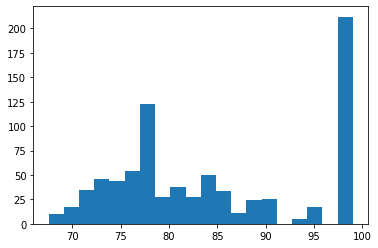

In [14]:
result.plot_hist('b', skip=200)

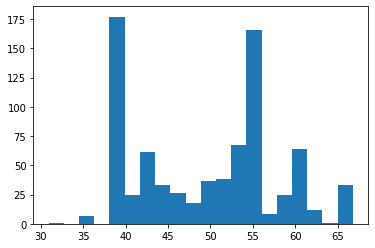

In [15]:
result.plot_hist('c', skip=200)

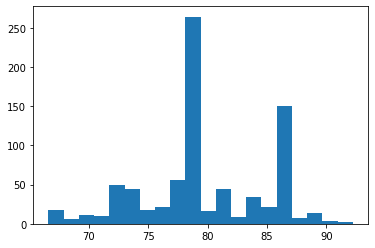

In [16]:
result.plot_hist('d', skip=200)